In [3]:
from clawpack import geoclaw
from clawpack.geoclaw import topotools as topo
from clawpack.geoclaw import dtopotools
import numpy as np
from matplotlib import pyplot as plt
from scipy import interpolate
import scipy
from itertools import product
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

## Define starting parameters and initialize helper functions

In [4]:
def simpsons(a,b,n,u,theta,v_0,down):
    """
    Find the area under our velocity function u. 
    Parameters:
    a (float): beginning number of seconds
    b (float): end number of seconds
    n (float): number of intervals in approximation
    theta (float): angle of slope, parameter for u
    v_0 (float): initial velocity, parameter for u
    """
    
    delta = (b - a) / n
    endpoints = [a]
    c = a
    for i in range(n):
        c = c + delta
        endpoints.append(c)
    inside_coeff = [4,2]*n
    coeff = [1] + inside_coeff[:(n-1)] + [1]

    return (delta / 3) * np.sum(u(np.array(endpoints), theta, v_0,down) * coeff)

In [5]:
# conversion functions (we assume that we are near the equator)
def deg_to_km(deg):
    return deg / .008

def km_to_deg(km):
    return km * .008

def m_to_deg(meters):
    return meters / 111000

def deg_to_m(deg):
    return deg * 111000



In [6]:
# read in topography file
topo_file = topo.Topography()
topo_file.read('./base.tt3', topo_type=3)
# create a function to interpolate bathymetry 
bathy = interpolate.RectBivariateSpline(topo_file.x, topo_file.y, topo_file.Z.transpose())

*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers


To calculate velocity we use the following equation
\begin{equation}
(p_sV)\frac{\partial u}{\partial t} = (p_s - p_w)gV[\sin(\theta) - f\cos(\theta)] - p_w\frac{C_Fld}{2}u^2
\end{equation}
For convenience we write

$$
a = (p_sV) \\ \\ \\
b= (p_s - p_w)gV[\sin(\theta) - f\cos(\theta)] \\ 
c = p_w\frac{C_Fld}{2} \\ 
$$
Then

\begin{equation}
u = \frac{\sqrt{b}\tanh(\frac{\sqrt{b}\sqrt{c} t}{a} + \tanh^{-1}(\frac{\sqrt{c}v_0}{\sqrt{b}}))}{\sqrt{c}}
,\quad u(0) = v_0
\end{equation}
Where

$$
p_s = \text{density of dirt} \\
V = \text{dlw : thickness x length x width : volume of mass} \\
p_w = \text{density of water} \\
g  = \text{gravity} \\
\theta = \text{slope of inclined plane} \\
f = tan(\phi) \quad \text{(Coulomb
friction coefficient: surface on surface)} \\
C_F = \text{surface skin friction (caused by the viscosity of water)}\\
l = \text{length} \\
w = \text{width}\\
d = \text{thickness}\\
$$

In [7]:
#starting parameters
p_w = 997 #(kg/m^3)
p_s = 1220 #(kg/m^3)
g = 9.8 #(m/s)
w = 15000 #(m)
l = 40000 #(m)
d = 50 #(m)
V = w*l*d #(m^3)
m_s = p_s*V #(kg)
f = 0.005
C_F = .009

In [8]:
def u(t,theta,v_0,down):
    """
    Find the velocity of landslide, with initial velocity v_0, moving down a slope with angle theta. 
    Parameters:
    theta (float): angle of slope in radians
    t (float): number of seconds landslide moves before velocity is measured
    v_0 (float): initial velocity
    """
    
    # define a, b and c according to our original pde
    a = p_s*V
    b = (p_s - p_w)*g*V*(np.sin(theta) - f*np.cos(theta))
    c = p_w*((C_F*l*d)/2)
    np.sqrt(np.abs(b) / np.sqrt(c))
    # if we are moving in the opposite direction of the slope we need to ensure our friction force is in the opposite direction of movement
    if down == False:
        b = (p_s - p_w)*g*V*(-np.sin(theta) - f*np.cos(theta))

    # our pde breaks into the following cases
    if b < 0 and v_0 >= 0:
        vel = - np.sqrt(-b)*np.tan(((np.sqrt(-b)*np.sqrt(c)*t)/a) 
                                    - np.arctan(np.sqrt(c)*v_0 / np.sqrt(-b))) / np.sqrt(c)
    if b > 0:
        if v_0 < np.sqrt(b) / np.sqrt(c):
            vel = np.sqrt(b)*np.tanh(((np.sqrt(b)*np.sqrt(c)*t)/a) 
                                    + np.arctanh(np.sqrt(c)*v_0 / np.sqrt(b))) / np.sqrt(c)
        if v_0 > np.sqrt(b) / np.sqrt(c):
            vel = np.sqrt(b)*(1/np.tanh(((np.sqrt(b)*np.sqrt(c)*t)/a) 
                                     + np.arctanh(np.sqrt(b) / (np.sqrt(c)*v_0)))) / np.sqrt(c)
    if isinstance(vel, float):
        if vel >=0:    
            return vel
        else:
            return 0
    else:
        vel[vel<0] = 0
        return vel

    

In [9]:
#test
down = True
seconds = 400
theta = .1
v_0 = u(seconds,theta,20, down)
print(v_0)
meters = simpsons(0,seconds,100,u,theta,v_0,down)
km_to_deg(meters)

87.64624288494274


387.2821272974536

In [10]:
def custom_div_cmap(numcolors=15, name='custom_div_cmap'):
    from matplotlib.colors import LinearSegmentedColormap 
    
    cmap = LinearSegmentedColormap.from_list(name=name, 
                                             colors =colors,
                                             N=numcolors)
    return cmap
colors = ['royalblue', 'royalblue', 'royalblue', 'CornflowerBlue','CornflowerBlue','CornflowerBlue','lightskyblue','lightskyblue','g', 'g', 'g']
cmap1 = custom_div_cmap(11, colors)
colors = ['royalblue', 'royalblue', 'royalblue', 'royalblue','CornflowerBlue','CornflowerBlue','CornflowerBlue','lightskyblue','lightskyblue','g', 'g', 'g','g','red']
cmap2 = custom_div_cmap(11, colors)


## Function for center of mass movement

In [11]:
def center_mass_path(coordinates, topo_file, seconds, max_iters, initial_vel, simpsons_n):
    """
    Find the path of centers of mass with starting position and initial velocity.
    Parameters:
    coordinates (list, [.,.]): starting coordinated in lon/lat
    topo_file: topography file 
    seconds (int): number of seconds for each step
    max_iters (int): maximum number of steps to take
    initial_vel (list, [.,.]): initial velocity of slide
    simpsons_n (int): number of intervals to use in simpsons approximation of the position
    """
    path = []
    grid_vel = []
    # find delta from original grid (less likely results will come from the interpolation)
    delta = np.max([topo_file.delta[0],topo_file.delta[0]])
    long_min, long_max, lat_min, lat_max = topo_file.extent
    thetas = []
    slope_vel = []
    signs_slope = []
    meters = []
    # determine elevation offsets
    elev1 = bathy(coordinates[0] + delta, coordinates[1])[0][0]
    elev2 = bathy(coordinates[0] - delta, coordinates[1])[0][0]
    elev3 = bathy(coordinates[0], coordinates[1] + delta)[0][0]
    elev4 = bathy(coordinates[0], coordinates[1] - delta)[0][0]
    # determine the direction of the slope (positive is up and right respectively)
    sign_lon = (elev2 - elev1) / np.abs(elev2 - elev1)
    sign_lat = (elev4 - elev3) / np.abs(elev4 - elev3)
        
    # find the angle of the slope determined by elevation offsets
    theta_lon = np.arctan(np.abs((elev1 - elev2)) / deg_to_m(2*delta))
    theta_lat = np.arctan(np.abs((elev3 - elev4)) / deg_to_m(2*delta))
    ratio = theta_lon / theta_lat
    v_lat_s = initial_vel / (ratio + 1) 
    v_lon_s = ratio * v_lat_s
    signs_vel = [sign_lon,sign_lat]

    for i in range(max_iters):
        # get the elevation at our current position
        elevation = bathy(coordinates[0],coordinates[1])[0][0]
        # get elevations at offsets in each dimension
        elev1 = bathy(coordinates[0] + delta, coordinates[1])[0][0]
        elev2 = bathy(coordinates[0] - delta, coordinates[1])[0][0]
        elev3 = bathy(coordinates[0], coordinates[1] + delta)[0][0]
        elev4 = bathy(coordinates[0], coordinates[1] - delta)[0][0]
        
        # store path
        path.append([elevation, coordinates[0], coordinates[1]])

        # determine the direction of the slope (positive is up and right respectively)
        sign_lon = (elev2 - elev1) / np.abs(elev2 - elev1)
        sign_lat = (elev4 - elev3) / np.abs(elev4 - elev3)
        signs_slope.append([sign_lon,sign_lat])
        
        # find the angle of the slope determined by elevation offsets
        theta_lon = np.arctan(np.abs((elev1 - elev2)) / deg_to_m(2*delta))
        theta_lat = np.arctan(np.abs((elev3 - elev4)) / deg_to_m(2*delta))
        thetas.append(np.array([theta_lon,theta_lat]))

        # if we are changing the direction we are moving in longitude
        if signs_slope[-1][0] != signs_vel[0]:
            v_lon_s = u(seconds,theta_lon,np.abs(v_lon_s),down = False)
            meters_lon_s = simpsons(0,seconds,simpsons_n,u,theta_lon,np.abs(v_lon_s),down = False)
            
        if signs_slope[-1][1] != signs_vel[1]:
            v_lat_s = u(seconds,theta_lat,np.abs(v_lat_s),down = False)
            meters_lat_s = simpsons(0,seconds,simpsons_n,u,theta_lat,np.abs(v_lat_s),down = False)
                
        # moving the same direction as before in longitude
        if signs_slope[-1][0] == signs_vel[0]:
            v_lon_s = u(seconds,theta_lon, np.abs(v_lon_s), down = True)
            meters_lon_s = simpsons(0,seconds,simpsons_n,u,theta_lon,np.abs(v_lon_s),down = True)

        if signs_slope[-1][1] == signs_vel[1]:
            v_lat_s = u(seconds,theta_lat, np.abs(v_lat_s), down = True)
            meters_lat_s = simpsons(0,seconds,simpsons_n,u,theta_lat,np.abs(v_lat_s), down = True)
       
        # store our velocity on the slope
        v_lon_s = np.abs(v_lon_s) * signs_vel[0]
        v_lat_s = np.abs(v_lat_s) * signs_vel[1]
        
        meters_lon_s = np.abs(meters_lon_s) * signs_vel[0]
        meters_lat_s = np.abs(meters_lat_s) * signs_vel[1]
        
        slope_vel.append([v_lon_s,v_lat_s])
        
        # find the velocity on the grid
        v_lat_g = np.cos(theta_lat)*v_lat_s
        v_lon_g = np.cos(theta_lon)*v_lon_s
        vel_g = np.array([v_lon_g,v_lat_g])
        grid_vel.append(vel_g)
        
        # find the distance moved on the grid
        meters_lat_g = np.cos(theta_lat)*meters_lat_s
        meters_lon_g = np.cos(theta_lon)*meters_lon_s
        meters_g = np.array([meters_lon_g,meters_lat_g])
        meters.append(meters_g)
        # move on grid
        coordinates = coordinates + m_to_deg(meters_g)
        # break statement using velocity
        if i >=30:
            if np.linalg.norm(slope_vel[-1]) < 10:
                break

        # out of bounds
        if coordinates[0] - delta < long_min or coordinates[0] + delta > long_max:
            print(f"out of longitude range at iteration {i+1}")
            break
        if coordinates[1] - delta < lat_min or coordinates[1] + delta > lat_max:
            print(f"out of lattitude range at iteration {i+1}")
            break
            
    path = np.array(path)
    points = np.array([path.T[1],path.T[2]]).T

    return points, grid_vel, slope_vel, thetas, signs_slope,meters

In [12]:
# test center of mass function
step_seconds = 1
initial_vel = 75
simpsons_n = 100
max_iter = 100000
num_files = 5 
start_coordinates = np.array([131.7,-5])

points1, grid_vel1, slope_vel1, thetas1, signs1, meters1 = center_mass_path(start_coordinates,
                                                       topo_file,step_seconds,max_iter,initial_vel,simpsons_n)

<IPython.core.display.Javascript object>


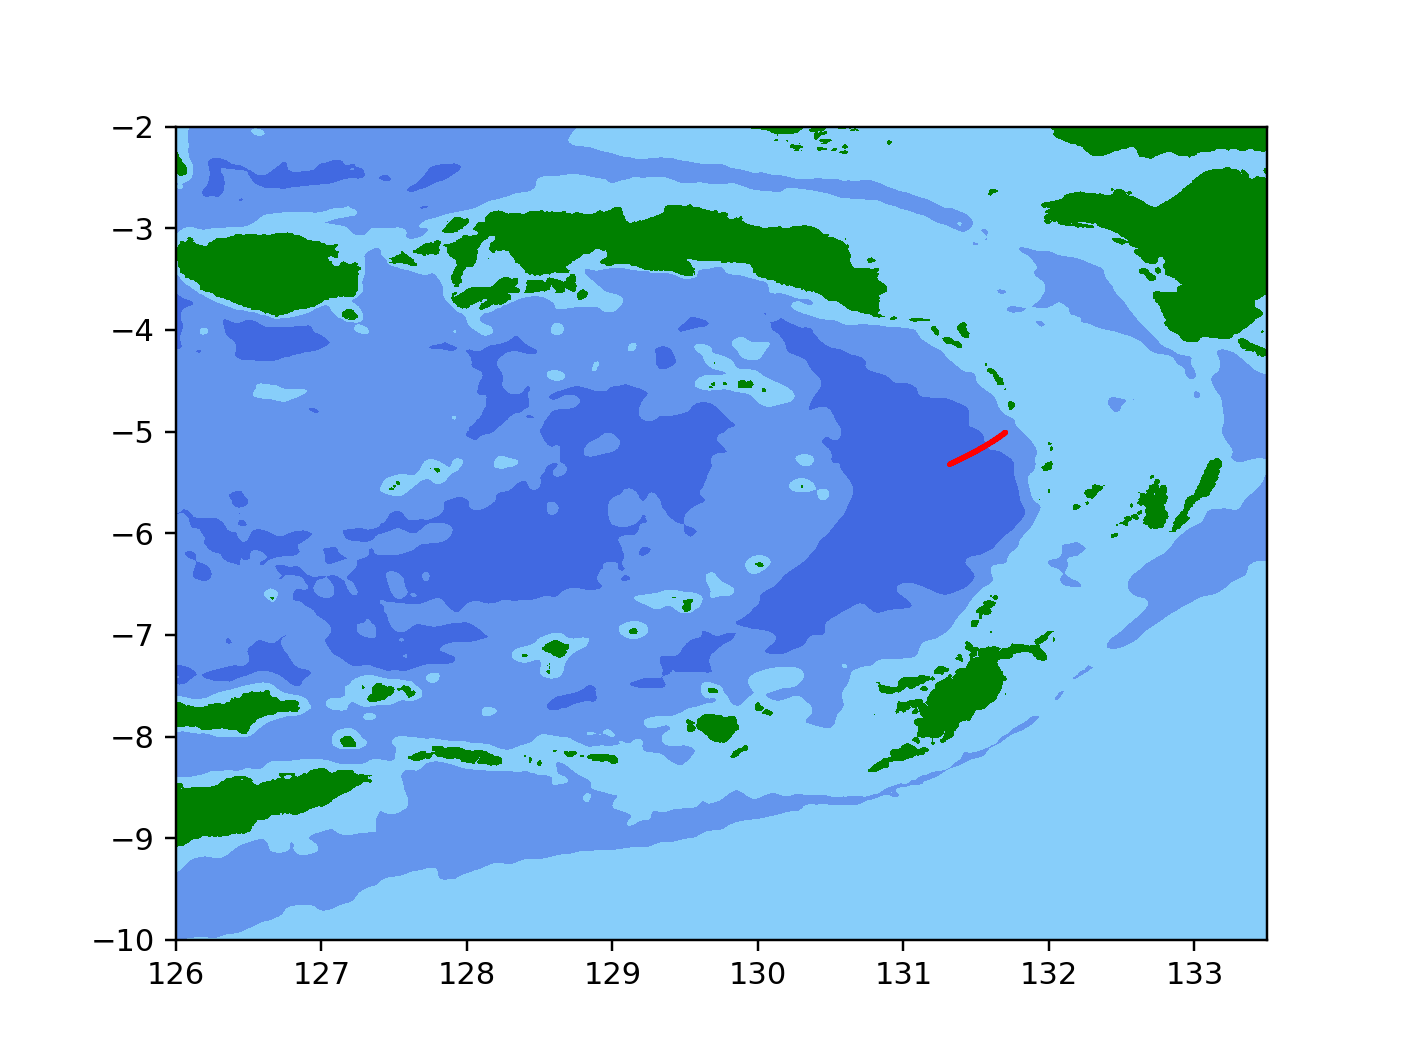

In [16]:
%matplotlib notebook
#plot the first ten minutes of the slide
plt.contourf(topo_file.X, topo_file.Y, topo_file.Z,cmap=cmap1)
for coordinate in points1[:600]:
    plt.plot(coordinate[0],coordinate[1],'ro',markersize = .5)


Text(0.5, 1.0, 'Up/Downslope Movement')

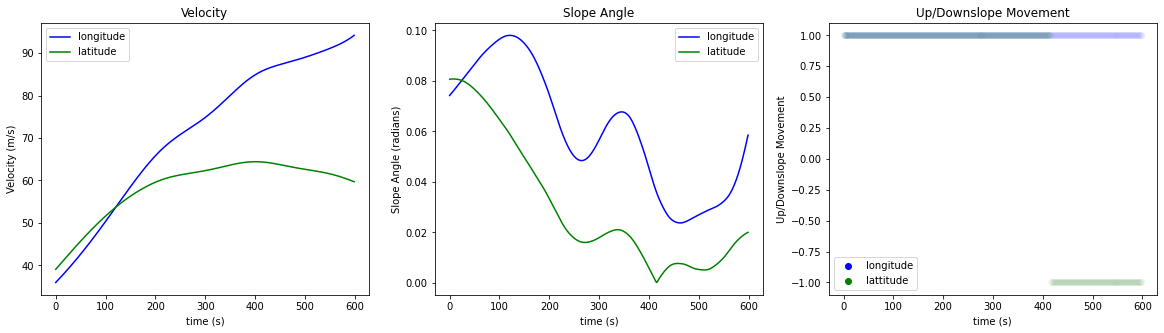

In [404]:
%matplotlib inline
plt.figure(figsize = (20,5))

plt.subplot(1,3,1)
plt.plot(np.abs(np.array(grid_vel1)[:,0][:600]),c = 'blue', label = 'longitude')
plt.plot(np.abs(np.array(grid_vel1)[:,1][:600]),c = 'green', label = 'latitude')
plt.xlabel('time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity')
plt.legend()

plt.subplot(1,3,2)
plt.plot(np.abs(np.array(thetas1)[:,0][:600]),c = 'blue', label = 'longitude')
plt.plot(np.abs(np.array(thetas1)[:,1][:600]),c = 'green', label = 'latitude')
plt.xlabel('time (s)')
plt.ylabel('Slope Angle (radians)')
plt.title('Slope Angle')
plt.legend()

plt.subplot(1,3,3)
plt.scatter(np.arange(len(signs1))[:600],-np.array(signs1)[:,0][:600],c = 'blue',alpha = .02, label = 'longitude')
plt.scatter(np.arange(len(signs1))[:600],-np.array(signs1)[:,1][:600],color = 'green',alpha = .02, label = 'lattitude')
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.ylabel('Up/Downslope Movement')
plt.xlabel('time (s)')
plt.title('Up/Downslope Movement')



Text(0.5, 0, 'Step')

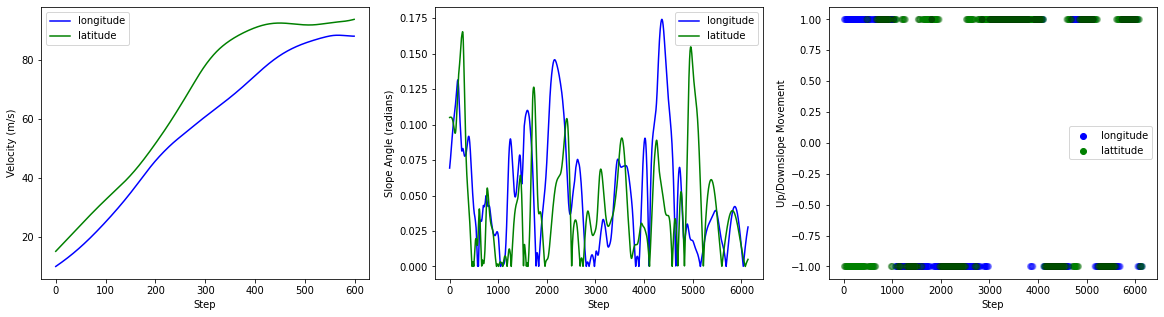

In [237]:
%matplotlib inline
plt.figure(figsize = (20,5))

plt.subplot(1,3,1)
plt.plot(np.abs(np.array(grid_vel2)[:,0][:600]),c = 'blue', label = 'longitude')
plt.plot(np.abs(np.array(grid_vel2)[:,1][:600]),c = 'green', label = 'latitude')
plt.xlabel('Step')
plt.ylabel('Velocity (m/s)')
plt.legend()

plt.subplot(1,3,2)
plt.plot(np.abs(np.array(thetas2)[:,0]),c = 'blue', label = 'longitude')
plt.plot(np.abs(np.array(thetas2)[:,1]),c = 'green', label = 'latitude')
plt.xlabel('Step')
plt.ylabel('Slope Angle (radians)')
plt.legend()

plt.subplot(1,3,3)
plt.scatter(np.arange(len(signs2)),-np.array(signs2)[:,0],c = 'blue',alpha = .02, label = 'longitude')
plt.scatter(np.arange(len(signs2)),-np.array(signs2)[:,1],color = 'green',alpha = .02, label = 'lattitude')
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.ylabel('Up/Downslope Movement')
plt.xlabel('Step')

#### Make center of mass plots for chains

In [312]:
chain1 = np.array([131.7,-6.3]) 
chain2 = np.array([131.7,-5]) 
chain3 = np.array([130.1,-6.3])
chain4 = np.array([130.5,-4]) 
chain5 = np.array([130.4,-5]) 
chain6 = np.array([130.3,-7.2]) 
loc_list = [chain1,chain1,chain2,chain2,chain3,chain3,chain6,chain6,chain4,chain5]
vel_list = [75,25,75,25,75,25,75,25,15,15]

In [342]:
w = 15000 #(m)
l = 40000 #(m)
d = 50 #(m)
points1, grid_vel1, slope_vel1, thetas1, signs1, meters1 = center_mass_path(chain1,
                                                       topo_file,step_seconds,max_iter,75,simpsons_n)
files1, centers_degrees1, step1 = landslide_boxes(points1[:600],d, w, l, 5, topo_file)

w = 15000 #(m)
l = 40000 #(m)
d = 50 #(m)
points2, grid_vel2, slope_vel2, thetas2, signs2, meters2 = center_mass_path(chain1,
                                                       topo_file,step_seconds,max_iter,25,simpsons_n)
files2, centers_degrees2 ,step2 = landslide_boxes(points2[:600],d, w, l, 5, topo_file)

w = 15000 #(m)
l = 40000 #(m)
d = 50 #(m)
points3, grid_vel3, slope_vel3, thetas3, signs3, meters3 = center_mass_path(chain2,
                                                       topo_file,step_seconds,max_iter,75,simpsons_n)
files3, centers_degrees3, step3 = landslide_boxes(points3[:600],d, w, l, 5, topo_file)

w = 15000 #(m)
l = 40000 #(m)
d = 50 #(m)
points4, grid_vel4, slope_vel4, thetas4, signs4, meters4 = center_mass_path(chain2,
                                                       topo_file,step_seconds,max_iter,25,simpsons_n)
files4, centers_degrees4, step4 = landslide_boxes(points4[:600],d, w, l, 5, topo_file)

w = 15000 #(m)
l = 40000 #(m)
d = 50 #(m)
points5, grid_vel5, slope_vel5, thetas5, signs5, meters5 = center_mass_path(chain6,
                                                       topo_file,step_seconds,max_iter,75,simpsons_n)
files5, centers_degrees5,step5 = landslide_boxes(points5[:600],d, w, l, 5, topo_file)

w = 15000 #(m)
l = 40000 #(m)
d = 50 #(m)
points6, grid_vel6, slope_vel6, thetas6, signs6, meters6 = center_mass_path(chain6,
                                                       topo_file,step_seconds,max_iter,25,simpsons_n)
files6, centers_degrees6,step6 = landslide_boxes(points6[:600],d, w, l, 5, topo_file)

w = 15000 #(m)
l = 40000 #(m)
d = 50 #(m)
points7, grid_vel7, slope_vel7, thetas7, signs7, meters7 = center_mass_path(chain3,
                                                       topo_file,step_seconds,max_iter,75,simpsons_n)
files7, centers_degrees7,step7 = landslide_boxes(points7[:600],d, w, l, 5, topo_file)

w = 15000 #(m)
l = 40000 #(m)
d = 50 #(m)
points8, grid_vel8, slope_vel8, thetas8, signs8, meters8 = center_mass_path(chain3,
                                                       topo_file,step_seconds,max_iter,25,simpsons_n)
files8, centers_degrees8,step8 = landslide_boxes(points8[:600],d, w, l, 5, topo_file)

w = 8660.254037844386 #(m)
l = 23094.01076758503 #(m)
d = 50 #(m)
points9, grid_vel9, slope_vel9, thetas9, signs9, meters9 = center_mass_path(chain4,
                                                       topo_file,step_seconds,max_iter,15,simpsons_n)
files9, centers_degrees9,step9 = landslide_boxes(points9[:600],d, w, l, 5, topo_file)

w = 10606.601717798212 #(m)
l = 28284.2712474619 #(m)
d = 50 #(m)
points10, grid10vel8, slope_vel10, thetas10, signs10, meters10 = center_mass_path(chain5,
                                                       topo_file,step_seconds,max_iter,15,simpsons_n)
files10, centers_degrees10,step10 = landslide_boxes(points10[:600],d, w, l, 5, topo_file)


pointsl = [points1,points2,points3,points4,points5,points6,points7,points8,points9,points10]
center_degrees_list = [centers_degrees1,centers_degrees2,centers_degrees3,centers_degrees4,centers_degrees5,centers_degrees6,
                 centers_degrees7,centers_degrees8,centers_degrees9,centers_degrees10]
files_list = [files1,files2,files3,files4,files5,files6,files7,files8,files9,files10]

Width used was 14800.000000296 m
Length used was 40700.000000814 m
*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers
*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers
*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers
*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers
*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers
Width used was 14800.000000296 m
Length used was 40700.000000814 m
*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers
*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers
*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers
*** Note: since grid regis

Text(0.5, 1.0, 'Landslide Center of Mass Movement')

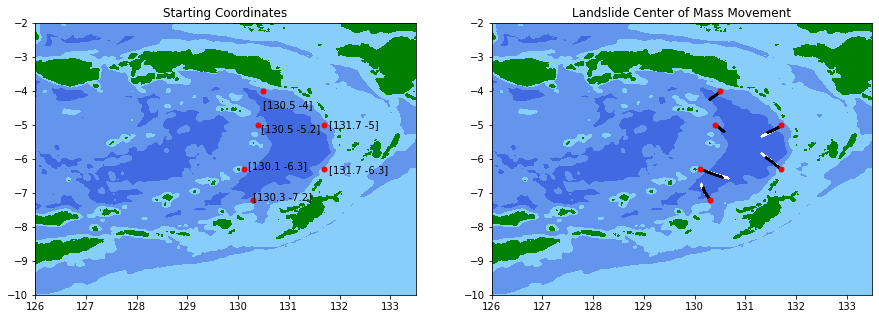

In [380]:
%matplotlib inline
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.contourf(topo_file.X, topo_file.Y, topo_file.Z,cmap=cmap1)
plt.plot(131.7,-6.3,'ro',markersize = 5)
plt.plot(131.7,-5,'ro',markersize = 5)
plt.plot(130.109804,-6.301292,'ro',markersize = 5)
plt.plot(130.5,-4,'ro',markersize = 5)
plt.plot(130.4,-5,'ro',markersize = 5) 
plt.plot(130.3,-7.2,'ro',markersize = 5)
plt.annotate('[131.7 -6.3]', (131.8, -6.4))
plt.annotate('[131.7 -5]', (131.8,-5.1))
plt.annotate('[130.1 -6.3]', (130.2,-6.301292))
plt.annotate('[130.5 -4]', (130.5,-4.5))
plt.annotate('[130.5 -5.2]', (130.45,-5.2))
plt.annotate('[130.3 -7.2]', (130.3,-7.2))

plt.title('Starting Coordinates')

plt.subplot(1,2,2)
plt.contourf(topo_file.X, topo_file.Y, topo_file.Z,cmap=cmap1)
colors = ['w','k','w','k','w','k','w','k','k','k']
i=0
for points in pointsl:
    for coordinate in points[:600]:
        plt.plot(coordinate[0],coordinate[1],'o',color = colors[i],markersize = .5)
    i = i+1
plt.plot(131.7,-6.3,'ro',markersize = 5)
plt.plot(131.7,-5,'ro',markersize = 5)
plt.plot(130.109804,-6.301292,'ro',markersize = 5)
plt.plot(130.5,-4,'ro',markersize = 5)
plt.plot(130.4,-5,'ro',markersize = 5) 
plt.plot(130.3,-7.2,'ro',markersize = 5)

plt.title('Landslide Center of Mass Movement')

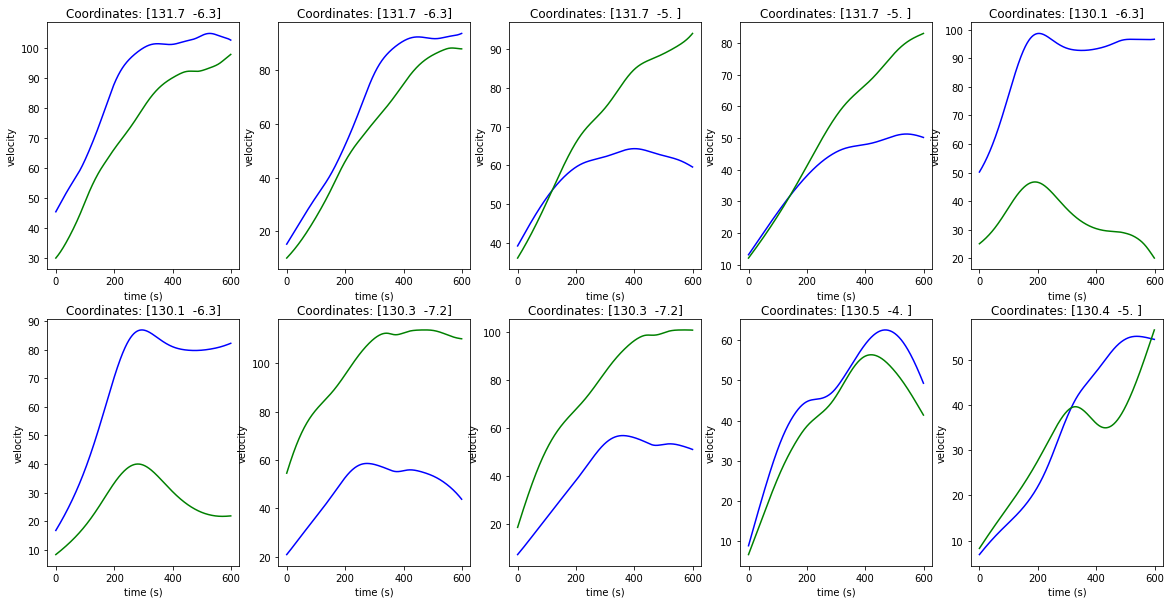

In [314]:
slope_velocities = [slope_vel1,slope_vel2,slope_vel3,slope_vel4,slope_vel5,slope_vel6,slope_vel7,slope_vel8,slope_vel9,slope_vel10]

plt.figure(figsize = (20,10))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.plot(np.abs(slope_velocities[i])[:,1][:600],c = 'b', label = 'lattitude')
    plt.plot(np.abs(slope_velocities[i])[:,0][:600],c = 'g', label = 'longitude')
    plt.title(f'Coordinates: {loc_list[i]}')
    plt.xlabel('time (s)')
    plt.ylabel('velocity')


## Function for landside boxes

In [48]:
# original function without angled boxes
def landslide_boxes(path,thickness,width,length,intermediate_steps,topo_file):
    
    files = []
    step = len(path) // intermediate_steps
    print(step)
    centers_degrees = []
    centers_position = []
    delta = topo_file.delta[0]
    
    #grid steps taken
    x_step = round((m_to_deg(length) / topo_file.delta[0]) / 2)
    y_step = round((m_to_deg(width) / topo_file.delta[0]) / 2)
    
    #print information about length and width
    print(f"Width used was {deg_to_m(y_step*2 * delta)} m")
    print(f"Length used was {deg_to_m(x_step*2 * delta)} m")
    print(f"delta is {deg_to_m(delta)} m")
    
    for i in np.arange(0,len(path),step):
        
        
        center = [path[i][0],path[i][1]]        
        x_center = np.argmin(np.abs(topo_file.x - center[0]))
        y_center = np.argmin(np.abs(topo_file.y - center[1]))
        center = [x_center,y_center]
          
        centers_degrees.append([topo_file.x[x_center],topo_file.y[y_center]])
        centers_position.append(center)
    
        #we need to actually read it in again
        topo_file_next = topo.Topography()
        topo_file_next.read('./base.tt3', topo_type=3)
        topo_file_next.Z = np.zeros_like(topo_file_next.Z)
        print(topo_file_next.Z[center[1] -y_step : center[1] +y_step, center[0]-x_step:center[0]+x_step].shape)
        print(np.ones((y_step*2,x_step*2)).shape)
        box = topo_file_next.Z[center[1] -y_step : center[1] +y_step, center[0]-x_step:center[0]+x_step]
        topo_file_next.Z[center[1] -y_step : center[1] +y_step, center[0]-x_step:center[0]+x_step] += np.ones_like(box)*thickness
        files.append(topo_file_next.Z)
        
    
    return files,centers_degrees,step



In [49]:
def F(A, theta):
    """Rotate the points in A about the origin by theta radians.
    Parameters:
    A ((2,n) ndarray): Array containing points in R2 stored as columns.
    theta (float): The rotation angle in radians.
    """
    B = np.array([[-np.cos(theta), np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    C = B @ A
    return C

In [50]:
def getfillPoints(corners, X):
    """
    Return the points from X inside a rectangle.
    Parameters:
    corners ((n,2) ndarray): Array containing points corresponding to the corners of our rectangle stored as rows.
    Must be in cyclical order.
    X ((n,2) ndarray): Array containing points, stored as rows, to check.
    """
    polygon = Polygon(corners)
    fillPoints = []
    for x in X:
        point = Point(x)
        if polygon.contains(point):
            fillPoints.append(x)
    return fillPoints

In [51]:
#new function with angled boxes

def landslide_boxes(points,thickness,width,length,intermediate_steps,topo_file):
    #append topography files
    files = []
    #append previous angles in case future angle is 0
    angles = [0]
    #step size based on the number of files wanted
    step = len(points) // intermediate_steps
    #list of discrete center of mass (lat/lon)
    centers_degrees = []
    #list of discrete center of mass (index in topo file)
    centers_position = []
    #distance between grid points on topography file
    delta_x = topo_file.delta[0]
    delta_y = topo_file.delta[1]
    #sign of angle rotation
    signs = []
    #dimesions of the box in grid steps taken
    x_step = np.max(np.array([round((m_to_deg(width) / delta_x) / 2),1]))
    y_step = np.max(np.array([round((m_to_deg(length) / delta_y) / 2),1]))
    #print information about length and width
    print(f"Width used was {deg_to_m(x_step*2 * delta_x)} m")
    print(f"Length used was {deg_to_m(y_step*2 * delta_y)} m")
    
    for i in np.arange(0,len(points),step):
        #get lists of the indices as well as lon/lat coordinates of our centers of mass
        center = [points[i][0],points[i][1]]        
        x_center = np.argmin(np.abs(topo_file.x - center[0]))
        y_center = np.argmin(np.abs(topo_file.y - center[1]))
        center = [x_center,y_center]
        centers_degrees.append([topo_file.x[x_center],topo_file.y[y_center]])
        centers_position.append(center)
    
    for j,i in enumerate(np.arange(0,len(points),step)):
        # current center of mass
        center = [points[i][0],points[i][1]]        
        x_center = np.argmin(np.abs(topo_file.x - center[0]))
        y_center = np.argmin(np.abs(topo_file.y - center[1]))
        center = [x_center,y_center]
          
        # find angle betwee current and next angle of mass (unless we are at the last point where we use the current and previous)
        if j == len(centers_degrees) - 1:
            point2 = np.array(centers_position[-2]) - np.array(center)
            #case where little distance is moved and multiple points may snap to the same point on the grid
            if np.any(point2) == 0:
                angle = angles[-1]
                angles.append(angle)
            else:
                #the last point uses the opposite sign angle as our last step (since it is current and previous)
                angle = -signs[-1]*np.arccos(point2[0]/np.sqrt(point2[0]**2 + point2[1]**2))
                angles.append(angle)
            
        else:
            point2 = np.array(centers_position[j + 1]) - np.array(center)
            #the sign for our angle of rotation depends on if we are in an upper or lower quadrant
            if np.sign(point2[1]) >= 0:
                sign = -1
            else:
                sign = 1
            signs.append(sign)
            #case where little distance is moved and multiple points may snap to the same point on the grid
            if np.any(point2) == 0:
                angle = angles[-1]
                angles.append(angle)
            else:
                angle = sign*np.arccos(point2[0]/np.sqrt(point2[0]**2 + point2[1]**2))
                angles.append(angle)
                
                
        # read in topography file and set elevation to 0
        topo_file_next = topo.Topography()
        topo_file_next.read('./base.tt3', topo_type=3)
        topo_file_next.Z = np.zeros_like(topo_file_next.Z)
        
        # get the coordinates of our box shifted centered at the origin
        box_coordinates_x =  np.arange(center[0] - x_step,center[0] + x_step + 1,1) - center[0]
        box_coordinates_y = np.arange(center[1] - y_step, center[1] + y_step + 1, 1) - center[1]
        box_grid = np.meshgrid(box_coordinates_x,box_coordinates_y)
        box_cord_list = np.append(box_grid[0].reshape(-1,1),box_grid[1].reshape(-1,1),axis=1).T
        
        # get the corners of our box
        x_max = np.max(box_cord_list[0])
        x_min = np.min(box_cord_list[0])
        y_max = np.max(box_cord_list[1])
        y_min = np.min(box_cord_list[1])
        # get the corners of our rotated box
        corners = np.array([[x_min, y_min],[x_min, y_max],[x_max,y_max],[x_max, y_min]])
        corners_rot = F(corners.T,angle).T

        # get gridpoints to check when we fill our polygon
        max_ = np.max(box_cord_list.T)
        x = np.arange(-max_,max_)
        X = np.meshgrid(x,x)
        grid_points = np.append(X[0].reshape(-1,1),X[1].reshape(-1,1),axis=1).T
        # now we fill missing points in the rectangle
        rect_filled = getfillPoints(corners_rot,grid_points.T)
        # rotate our original rectangle
        rotate = F(box_cord_list, angle)
        # snap to grid points
        rotate = np.rint(rotate).astype(int)
        # combine with filled rectangle
        end_rect = np.vstack((rotate.T,rect_filled))
        end_rect = np.unique(end_rect, axis=0)
        # shift back to center
        end_rect = end_rect.T
        end_rect[0] += center[0]
        end_rect[1] += center[1]
        end_rect = end_rect.T
        end_rect = np.array([end_rect.T[1],end_rect.T[0]])
        #add mass to topography file
        topo_file_next.Z[tuple(end_rect.astype(int))] += thickness 
        files.append(topo_file_next.Z)
    
    return files,centers_degrees, step


In [385]:
files, centers_degrees,step = landslide_boxes(points1[:600],d, w, l, 5, topo_file)

Width used was 11100.000000222 m
Length used was 29600.000000592 m
*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers
*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers
*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers
*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers
*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers


#### plots for all chains

Text(0.5, 1.0, 'Volume Displacement')

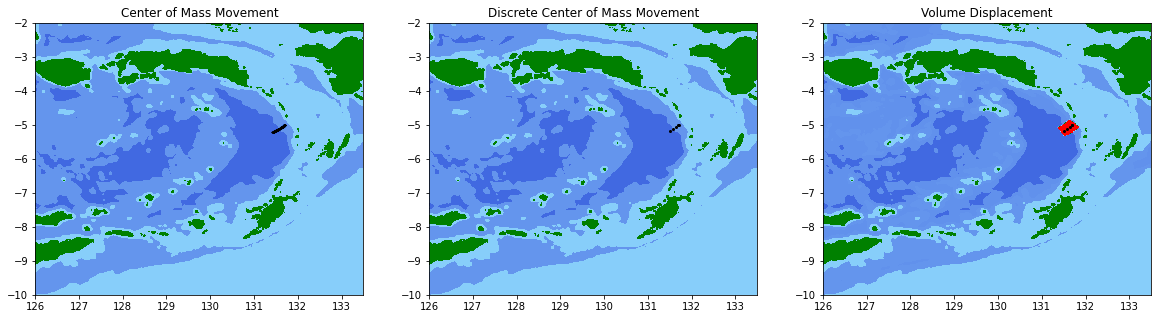

In [392]:
%matplotlib inline
plt.figure(figsize = (20,5))
######################################################################
plt.subplot(1,3,1)
plt.contourf(topo_file.X, topo_file.Y, topo_file.Z,cmap=cmap1)
for coordinate in points1[:600]:
    plt.plot(coordinate[0],coordinate[1],'ko',markersize = .5)
plt.title('Center of Mass Movement')

######################################################################
plt.subplot(1,3,2)
plt.contourf(topo_file.X, topo_file.Y, topo_file.Z,cmap=cmap1)
for theta in centers_degrees:
    plt.plot(theta[0],theta[1],'ko',markersize = 2)
plt.title('Discrete Center of Mass Movement')
######################################################################
plt.subplot(1,3,3)

#visualize boxes
dz_boxes = topo_file.Z.copy() 
for i in range(len(files)):
    dz_boxes[np.where(files[i] !=0)] = 4000

plt.contourf(topo_file.X, topo_file.Y,dz_boxes,cmap=cmap2)
for theta in centers_degrees:
    plt.plot(theta[0],theta[1],'ko',markersize = 2)
    
plt.title('Volume Displacement')

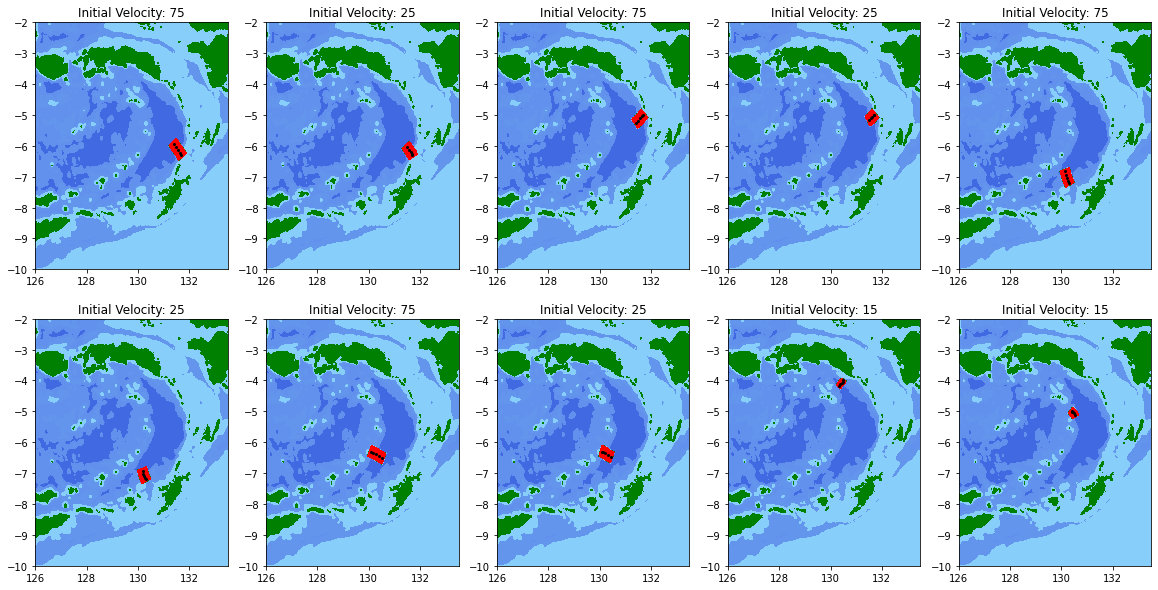

In [359]:
plt.figure(figsize = (20,10))

for j in range(10):
    plt.subplot(2,5,j+1)
    dz_boxes = topo_file.Z.copy() 
    for i in range(len(files)):
        dz_boxes[np.where(files_list[j][i] !=0)] = 4000

    plt.contourf(topo_file.X, topo_file.Y,dz_boxes,cmap=cmap2)
    for theta in center_degrees_list[j]:
        plt.plot(theta[0],theta[1],'ko',markersize = 2)
        plt.title(f'Initial Velocity: {vel_list[j]}')

## Create dtopo file

In [1227]:
dpath = '/Users/raelynnwonnacott/Desktop/Dtopo_Files/dtopo2.tt3'
num_points = 600 // step_seconds
points = points1[:num_points]
#place boxes around discrete center of mass movement
files, centers_degrees, step = landslide_boxes(points,d, w, l, num_files, topo_file)
#create dtopo file for geoclaw
dtopo = dtopotools.DTopography()
dtopo.x = topo_file.x
dtopo.y = topo_file.y
dtopo.X = topo_file.X
dtopo.Y = topo_file.Y
time_step = step * step_seconds
dtopo_times = np.array([0,time_step*1,time_step*2,time_step*3,time_step*4])
dtopo.times = dtopo_times
x_shape, y_shape = files[0].shape
dZ = np.zeros((len(files),x_shape,y_shape))
for i in range(len(files)):
    dZ[i] = files[-i]
dtopo.dZ = dZ
print(time_step)
dtopo.write(dpath, dtopo_type=3)



Width used was 14800.000000296 m
Length used was 40700.000000814 m
*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers
*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers
*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers
*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers
*** Note: since grid registration is llcorner,
    will shift x,y values by (dx/2, dy/2) to cell centers
120


## Random plots

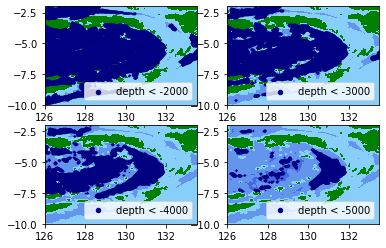

In [428]:
plt.subplot(2,2,1)
ind = np.where((topo_file.Z < 0) & (topo_file.Z < -2000 ))
y_cord = topo_file.y[ind[0]]
x_cord = topo_file.x[ind[1]]
plt.contourf(topo_file.X, topo_file.Y, topo_file.Z,cmap=cmap1)
plt.scatter(x_cord,y_cord,c ='navy',s = .2,label = f'depth < {-2000}')
plt.legend(loc = 'lower right',markerscale = 10)

plt.subplot(2,2,2)
ind = np.where((topo_file.Z < 0) & (topo_file.Z < -3000 ))
y_cord = topo_file.y[ind[0]]
x_cord = topo_file.x[ind[1]]
plt.contourf(topo_file.X, topo_file.Y, topo_file.Z,cmap=cmap1)
plt.scatter(x_cord,y_cord,c ='navy',s = .2,label = f'depth < {-3000}')
plt.legend(loc = 'lower right',markerscale = 10)

plt.subplot(2,2,3)
ind = np.where((topo_file.Z < 0) & (topo_file.Z < -4000 ))
y_cord = topo_file.y[ind[0]]
x_cord = topo_file.x[ind[1]]
plt.contourf(topo_file.X, topo_file.Y, topo_file.Z,cmap=cmap1)
plt.scatter(x_cord,y_cord,c ='navy',s = .2,label = f'depth < {-4000}')
plt.legend(loc = 'lower right',markerscale = 10)

plt.subplot(2,2,4)
ind = np.where((topo_file.Z < 0) & (topo_file.Z < -5000 ))
y_cord = topo_file.y[ind[0]]
x_cord = topo_file.x[ind[1]]
plt.contourf(topo_file.X, topo_file.Y, topo_file.Z,cmap=cmap1)
plt.scatter(x_cord,y_cord,c ='navy',s = .2,label = f'depth < {-5000}')
plt.legend(loc = 'lower right',markerscale = 10)

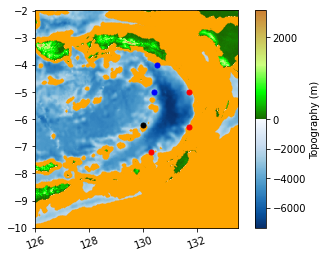

In [405]:
topo_file.plot()
plt.scatter(x_cord,y_cord,c ='orange',s = .2)
plt.plot(131.7,-6.3,'ro',markersize = 5)
plt.plot(131.7,-5,'ro',markersize = 5)
plt.plot(130,-6.2,'ko',markersize = 5)
plt.plot(130.5,-4,'bo',markersize = 5) #(reduced volume)
plt.plot(130.4,-5,'bo',markersize = 5) #(reduced velocity)
plt.plot(130.3,-7.2,'ro',markersize = 5)
